In [4]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import datetime as dt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline


#Data Cleaning

###Yield data

In [ ]:
# crop production data
crop_yield = pd.read_csv('/content/Production_Crops_Livestock_E_All_Data.csv')
crop_yield[:3]

FileNotFoundError: ignored

In [ ]:
crop_yield['Area'].unique()

The data seems to include groups of countries or regions so we will drop those 

In [ ]:
drop_rows = ['World', 'Africa', 'Eastern Africa', 'Middle Africa', 'Northern Africa','Southern Africa', 'Western Africa', 'Americas',\
       'Northern America', 'Central America', 'Caribbean','South America', 'Asia', 'Central Asia', 'Eastern Asia',\
       'Southern Asia', 'South-eastern Asia', 'Western Asia', 'Europe', 'Eastern Europe', 'Northern Europe', 'Southern Europe',\
       'Western Europe', 'Oceania', 'Australia and New Zealand', 'Melanesia', 'Micronesia', 'Polynesia', 'European Union (27)',\
       'Least Developed Countries', 'Land Locked Developing Countries', 'Small Island Developing States',\
       'Low Income Food Deficit Countries', 'Net Food Importing Developing Countries']
corp_yield_countries = crop_yield.loc[~crop_yield['Area'].isin(drop_rows)]

In [ ]:
# getting the yield columns with float values and renaming them
yield_columns = list(corp_yield_countries.select_dtypes(include=[float]).columns)

# getting only the columns that are going to be used for EDA and modelling
select_columns = ['Area', 'Item', 'Element', 'Unit'] + [col[1:] for col in yield_columns]
yield_columns = {col:col[1:] for col in yield_columns}
corp_yield_countries = corp_yield_countries.rename(columns=yield_columns)
corp_yield_countries = corp_yield_countries[select_columns]

# As we are intrested in the yield we will drop the rows where elements are Area harvested and production
corp_yield_by_country = corp_yield_countries[corp_yield_countries['Element'] == 'Yield']

In [ ]:
corp_yield_by_country = corp_yield_by_country.fillna(0)
corp_yield_by_country.head()

In [ ]:
# Getting the top 100 crops aggregating by its production in year 2020
top_100_items = list(corp_yield_by_country.groupby('Item')['2020'].sum().sort_values().reset_index()[-100:]['Item'])

# shortening the list to essential 33 crops manually picked from the top 100 list
essential_33 = ['Cassava, fresh', 'Wheat', 'Maize (corn)', 'Rice', 'Barley', 'Millet', 'Seed cotton, unginned', 'Groundnuts, excluding shelled', 'Oil palm fruit',\
       'Potatoes', 'Rye', 'Soya beans', 'Sugar cane', 'Sunflower seed', 'Cereals, Total', 'Tomatoes', 'Peas, green', 'Tea leaves', 'Beans, dry',\
       'Bananas', 'Oranges', 'Almonds, in shell', 'Lettuce and chicory', 'Cocoa beans', 'Coffee, green', 'Carrots and turnips', 'Mushrooms and truffles',\
       'Cabbages', 'Onions and shallots, dry (excluding dehydrated)', 'Bananas', 'Pumpkins, squash and gourds', 'Citrus Fruit, Total', 'Lemons and limes']

# Fetching the related data
corp_yield_by_country_33 = corp_yield_by_country.loc[corp_yield_by_country['Item'].isin(essential_33)]

In [ ]:
print('Number of countries growing the essential crops:', len(corp_yield_by_country_33['Area'].unique()))

In [ ]:
rename_lst = [('Maize (corn)', 'Maize'), ('Seed cotton, unginned', 'Cotton'), ('Groundnuts, excluding shelled', 'Groundnuts'), ('Tea leaves', 'Tea'),\
              ('Oil palm fruit', 'Oil palm'), ('Mushrooms and truffles', 'Mushrooms'), ('Onions and shallots, dry (excluding dehydrated)', 'Onions'),\
              ('Pumpkins, squash and gourds', 'Pumpkins'), ('Carrots and turnips', 'Carrots'), ('Lettuce and chicory', 'Lettuce'), ('Beans, dry', 'Beans'),\
              ('Almonds, in shell', 'Almonds'), ('Cereals, Total', 'Cereals'), ('Citrus Fruit, Total', 'Fruits'), ('Lemons and limes', 'Lemons')]
for old, new in rename_lst:
  corp_yield_by_country_33.loc[corp_yield_by_country_33.Item == old, 'Item'] = new
corp_yield_by_country_33.reset_index()

#### ARIMA univarite yield prediction

In [ ]:
# Prediction of yield - country wise for each crop
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from math import sqrt

crop_yield = []
yield_2021 = []
yield_rmse = []
size = int(60 * 0.75) # test train split size

for idx, row in tqdm(corp_yield_by_country_33.iterrows()):
  X = list(row[4:])
  crop_yield.append(X)
  train, test = X[0:size], X[size:60]
  history = [x for x in train if x != 0]
  predictions = list()
  if len(history) >= 10:
    # walk-forward validation for past 25 years
    for t in range(len(test)):
      model = ARIMA(history)
      model_fit = model.fit()
      output = model_fit.forecast()
      yhat = output[0]
      predictions.append(yhat)
      obs = test[t]
      history.append(obs)

  # future yield prediction for year 2021
    model = ARIMA(history)
    model_fit = model.fit()
    yield_2021.append(model_fit.forecast()[0])

    rmse = sqrt(mean_squared_error(test, predictions))
    yield_rmse.append(rmse)

  else:
    yield_2021.append(0)
    yield_rmse.append(0)

corp_yield_by_country_33['2021'] = yield_2021
corp_yield_by_country_33['yield_rmse'] = yield_rmse

In [ ]:
corp_yield_by_country_33.to_csv('corp_yield_by_country_33.csv')

In [ ]:
corp_yield_by_country_33.head()

In [ ]:
corp_yield_by_country_33.sort_values('yield_rmse')[-20:]

### Temperature Data

In [ ]:
corp_yield_by_country_33 = pd.read_csv('/content/corp_yield_by_country_33.csv')
temperature = pd.read_csv('/content/Environment_Temperature_change_E_All_Data.csv')
temperature[:3]

In [ ]:
drop_rows = ['World', 'Africa', 'Eastern Africa', 'Middle Africa', 'Northern Africa','Southern Africa', 'Western Africa', 'Americas',\
       'Northern America', 'Central America', 'Caribbean','South America', 'Asia', 'Central Asia', 'Eastern Asia',\
       'Southern Asia', 'South-eastern Asia', 'Western Asia', 'Europe', 'Eastern Europe', 'Northern Europe', 'Southern Europe',\
       'Western Europe', 'Oceania', 'Australia and New Zealand', 'Melanesia', 'Micronesia', 'Polynesia', 'European Union (27)',\
       'Least Developed Countries', 'Land Locked Developing Countries', 'Small Island Developing States',\
       'Low Income Food Deficit Countries', 'Net Food Importing Developing Countries']
temperature_countries = temperature.loc[~temperature['Area'].isin(drop_rows)]

In [ ]:
# getting the temperature columns with float values and renaming them
temp_columns = list(temperature_countries.select_dtypes(include=[float]).columns)

# getting only the columns that are going to be used for EDA and modelling
select_columns = ['Area', 'Months', 'Element', 'Unit'] + [col[1:] for col in temp_columns]
temp_columns = {col:col[1:] for col in temp_columns}
temperature_countries = temperature_countries.rename(columns=temp_columns)
temperature_countries = temperature_countries[select_columns]

# As we are intrested in the temperature we will drop the rows where elements is Temperature change
temperature_by_country = temperature_countries[temperature_countries['Element'] == 'Temperature change']

In [ ]:
temperature_by_country = temperature_by_country.groupby('Area').mean().reset_index()
countries = corp_yield_by_country_33['Area'].unique()

# Fetching the related data
temperature_by_country = temperature_by_country.loc[temperature_by_country['Area'].isin(countries)]

In [ ]:
temperature_by_country.tail()

In [ ]:
# From the below chart we can see that the temperature also has been changing like yield
# So this may be a valuable data which can help predict yield better
print(temperature_by_country.iloc[197]['Area'])
plt.plot(temperature_by_country.iloc[197,1:])

In [ ]:
# imputing the Nan values using temperature of previous year
for i, col in enumerate(temperature_by_country[temperature_by_country.columns[2:]]):
  temperature_by_country[col] = temperature_by_country[col].fillna(temperature_by_country.iloc[:,i+1])

# verifying if values are imputed
plt.plot(list(temperature_by_country[temperature_by_country['Area']=='Yemen'].iloc[0,1:]))

In [ ]:
temperature_by_country.to_csv('temperature_by_country.csv')

### Pesticide

In [ ]:
corp_yield_by_country_33 = pd.read_csv('/content/corp_yield_by_country_33.csv')
temperature_by_country = pd.read_csv('/content/temperature_by_country.csv')
pesticide = pd.read_csv('/content/Inputs_Pesticides_Use_E_All_Data.csv')
pesticide.head()

In [ ]:
drop_rows = ['World', 'Africa', 'Eastern Africa', 'Middle Africa', 'Northern Africa','Southern Africa', 'Western Africa', 'Americas',\
       'Northern America', 'Central America', 'Caribbean','South America', 'Asia', 'Central Asia', 'Eastern Asia',\
       'Southern Asia', 'South-eastern Asia', 'Western Asia', 'Europe', 'Eastern Europe', 'Northern Europe', 'Southern Europe',\
       'Western Europe', 'Oceania', 'Australia and New Zealand', 'Melanesia', 'Micronesia', 'Polynesia', 'European Union (27)',\
       'Least Developed Countries', 'Land Locked Developing Countries', 'Small Island Developing States',\
       'Low Income Food Deficit Countries', 'Net Food Importing Developing Countries']
pesticide_countries = pesticide.loc[~pesticide['Area'].isin(drop_rows)]
# getting the pesticide columns with float values and renaming them
pest_columns = list(pesticide_countries.select_dtypes(include=[float]).columns)

# getting only the columns that are going to be used for EDA and modelling
select_columns = ['Area', 'Item'] + [col[1:] for col in pest_columns]
pest_columns = {col:col[1:] for col in pest_columns}
pesticide_countries = pesticide_countries.rename(columns=pest_columns)
pesticide_countries = pesticide_countries[select_columns]

pesticide_countries = pesticide_countries.fillna(0)

In [ ]:
# checking if pesticide use show any significant pattern across years
plt.plot(list(pesticide_countries[pesticide_countries['Area']=='Albania'].iloc[0,2:]))

In [ ]:
pesticide_countries = pesticide_countries.groupby(['Area', 'Item']).mean().reset_index()
countries = corp_yield_by_country_33['Area'].unique()

# Fetching the related data
pesticide_countries = pesticide_countries.loc[pesticide_countries['Area'].isin(countries)]
pesticide_countries.head()

In [ ]:
pesticide_countries = pesticide_countries.groupby('Area').sum().reset_index()


In [ ]:
new_rows = {'Area': [area for area in countries if area not in pesticide_countries['Area']]}
for i in range(1990, 2021):
  new_rows[str(i)] = [0] * len(new_rows['Area'])
new_rows = pd.DataFrame(new_rows)
pesticide_countries = pesticide_countries.append(new_rows)
pesticide_countries = pesticide_countries[pesticide_countries['Area'].isin(countries)]

In [ ]:
pesticide_countries = pesticide_countries.groupby(['Area']).sum().reset_index()

In [ ]:
empty_vals = [0 for i in range(len(pesticide_countries))]
for i in range(1961,1990):
  pesticide_countries.loc[:,str(i)] = empty_vals

In [ ]:
pesticide_countries.to_csv('pesticide_final.csv')

### Land Use

In [ ]:
corp_yield_by_country_33 = pd.read_csv('/content/corp_yield_by_country_33.csv')
temperature_by_country = pd.read_csv('/content/temperature_by_country.csv')
pesticide = pd.read_csv('/content/pesticide_final.csv')
land_use_by_counry = pd.read_csv('/content/Inputs_LandUse_E_All_Data.csv')
land_use_by_counry.head(5)

In [ ]:
selected_land = ['Agriculture area actually irrigated', 'Agriculture', 'Land area actually irrigated', 'Agriculture area actually irrigated']
landuse_countries = land_use_by_counry.loc[land_use_by_counry['Item'].isin(selected_land)]


In [ ]:
drop_rows = ['World', 'Africa', 'Eastern Africa', 'Middle Africa', 'Northern Africa','Southern Africa', 'Western Africa', 'Americas',\
       'Northern America', 'Central America', 'Caribbean','South America', 'Asia', 'Central Asia', 'Eastern Asia',\
       'Southern Asia', 'South-eastern Asia', 'Western Asia', 'Europe', 'Eastern Europe', 'Northern Europe', 'Southern Europe',\
       'Western Europe', 'Oceania', 'Australia and New Zealand', 'Melanesia', 'Micronesia', 'Polynesia', 'European Union (27)',\
       'Least Developed Countries', 'Land Locked Developing Countries', 'Small Island Developing States',\
       'Low Income Food Deficit Countries', 'Net Food Importing Developing Countries']
landuse_countries = landuse_countries.loc[~landuse_countries['Area'].isin(drop_rows)]
# getting the pesticide columns with float values and renaming them
land_columns = list(landuse_countries.select_dtypes(include=[float]).columns)

# getting only the columns that are going to be used for EDA and modelling
select_columns = ['Area'] + [col[1:] for col in land_columns]
land_columns = {col:col[1:] for col in land_columns}
landuse_countries = landuse_countries.rename(columns=land_columns)
landuse_countries = landuse_countries[select_columns]

landuse_countries = landuse_countries.fillna(0)

In [ ]:
landuse_countries = landuse_countries.groupby(['Area']).sum().reset_index()
countries = corp_yield_by_country_33['Area'].unique()

# Fetching the related data
landuse_countries = landuse_countries.loc[landuse_countries['Area'].isin(countries)]
landuse_countries.head()

In [ ]:
# checking if land use show any significant pattern across years
plt.plot(list(landuse_countries[landuse_countries['Area']=='India'].iloc[0,2:]))

In [ ]:
landuse_countries.to_csv('landuse_countries_final.csv')

### Fertilizer

In [2]:
corp_yield_by_country = pd.read_csv('/content/Crop_by_country_final.csv')
temperature_by_country = pd.read_csv('/content/temperature_by_country.csv')
pesticide = pd.read_csv('/content/pesticide_final.csv')
land_use_by_counry = pd.read_csv('/content/landuse_countries_final.csv')
fertilizer_by_counry = pd.read_csv('/content/fertilizer_by_counry.csv')
fertilizer_by_counry.head(5)

NameError: ignored

In [ ]:
fertilizer_by_counry.fillna(0, inplace=True)
fertilizer_by_counry = fertilizer_by_counry.loc[fertilizer_by_counry['Element'] == 'Agricultural Use']

In [ ]:
drop_rows = ['World', 'Africa', 'Eastern Africa', 'Middle Africa', 'Northern Africa','Southern Africa', 'Western Africa', 'Americas',\
       'Northern America', 'Central America', 'Caribbean','South America', 'Asia', 'Central Asia', 'Eastern Asia',\
       'Southern Asia', 'South-eastern Asia', 'Western Asia', 'Europe', 'Eastern Europe', 'Northern Europe', 'Southern Europe',\
       'Western Europe', 'Oceania', 'Australia and New Zealand', 'Melanesia', 'Micronesia', 'Polynesia', 'European Union (27)',\
       'Least Developed Countries', 'Land Locked Developing Countries', 'Small Island Developing States',\
       'Low Income Food Deficit Countries', 'Net Food Importing Developing Countries']
fertilizer_by_counry = fertilizer_by_counry.loc[~fertilizer_by_counry['Area'].isin(drop_rows)]
# getting the pesticide columns with float values and renaming them
fert_columns = list(fertilizer_by_counry.select_dtypes(include=[float]).columns)

# getting only the columns that are going to be used for EDA and modelling
select_columns = ['Area'] + [col[1:] for col in fert_columns]
fert_columns = {col:col[1:] for col in fert_columns}
fertilizer_by_counry = fertilizer_by_counry.rename(columns=fert_columns)
fertilizer_by_counry = fertilizer_by_counry[select_columns]

In [ ]:
fertilizer_by_counry = fertilizer_by_counry.groupby(['Area']).sum().reset_index()
countries = corp_yield_by_country_33['Area'].unique()

# Fetching the related data
fertilizer_by_counry = fertilizer_by_counry.loc[fertilizer_by_counry['Area'].isin(countries)]
fertilizer_by_counry.head()

In [ ]:
new_rows = {'Area': [area for area in countries if area not in fertilizer_by_counry['Area']]}
for i in range(1961, 2021):
  new_rows[str(i)] = [0] * len(new_rows['Area'])
new_rows = pd.DataFrame(new_rows)
fertilizer_by_counry = fertilizer_by_counry.append(new_rows)
fertilizer_by_counry = fertilizer_by_counry[fertilizer_by_counry['Area'].isin(countries)]

In [ ]:
fertilizer_by_counry = fertilizer_by_counry.groupby(['Area']).sum().reset_index()

In [ ]:
# checking if pesticide use show any significant pattern across years
plt.plot(list(fertilizer_by_counry[fertilizer_by_counry['Area']=='India'].iloc[0,2:]))

In [ ]:
fertilizer_by_counry.to_csv('fertilizer_by_counry.csv')

### Rainfall

Data Exploration

## Modeling

In [5]:
corp_yield_by_country = pd.read_csv('/content/Crop_by_country_final.csv')
temperature_by_country = pd.read_csv('/content/temperature_by_country.csv')
pesticide = pd.read_csv('/content/pesticide_final.csv')
land_use_by_counry = pd.read_csv('/content/landuse_countries_final.csv')
fertilizer_by_counry = pd.read_csv('/content/fertilizer_by_counry.csv')

In [5]:
corp_yield_by_country.head()

,Unnamed: 0,Area,Item,Element,Unit,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,yield_rmse,CID
0,0,Afghanistan,Almonds,Yield,hg/ha,0.0,0.0,0.0,0.0,0.0,...,19996.0,16521.0,16859.0,13788.0,17161.0,13083.0,17759.0,20324.400000,15077.145923,AFG
1,1,Afghanistan,Barley,Yield,hg/ha,10800.0,10800.0,10800.0,10857.0,10857.0,...,15213.0,14291.0,13770.0,13933.0,6748.0,14699.0,14838.0,11932.921758,4998.769347,AFG
2,2,Afghanistan,Maize,Yield,hg/ha,14000.0,14000.0,14260.0,14257.0,14400.0,...,24882.0,21457.0,20517.0,12957.0,14727.0,19457.0,19344.0,17156.389623,5830.088479,AFG
3,3,Afghanistan,Millet,Yield,hg/ha,8085.0,8163.0,8235.0,8302.0,8364.0,...,24845.0,23201.0,22269.0,21865.0,20729.0,19372.0,13187.0,11730.271760,12993.961276,AFG
4,4,Afghanistan,Onions,Yield,hg/ha,0.0,0.0,0.0,0.0,0.0,...,138337.0,138357.0,106223.0,119632.0,146201.0,192294.0,168470.0,160326.766667,29639.046714,AFG


In [6]:
scaled_corp_yield_by_country = corp_yield_by_country.copy(deep = True)

In [7]:
cols = ['yield_rmse']

In [8]:
ss = MinMaxScaler()
yield_scaled = pd.DataFrame(ss.fit_transform(scaled_corp_yield_by_country[['yield_rmse']]),columns = cols)

rmse = np.mean(yield_scaled['yield_rmse'])
print("Avg RMSE for ARIMA Model is:", round(rmse, 5))

Avg RMSE for ARIMA Model is: 0.0035


In [9]:
data = corp_yield_by_country
value_vars = [str(val) for val in range(1961,2022)]
data = data.drop(['Unnamed: 0', 'Element', 'Unit', 'yield_rmse'], axis=1)
data = data.melt(id_vars=["Area", "CID", "Item"], 
        var_name="Date", 
        value_name="Yield")
data = data.sort_values(['Area', 'Item']).reset_index()
crop_data = data.drop('index', axis=1)

In [10]:
def change_data(data, column):
  value_vars = [str(val) for val in range(1961,2022)]
  data = data.drop(['Unnamed: 0'], axis=1)
  data = data.melt(id_vars=["Area"], 
          var_name="Date", 
          value_name=column)
  data = data.sort_values(['Area']).reset_index()
  return data.drop('index', axis=1)

In [11]:
pest_data = change_data(pesticide, 'pesticide')
land_data = change_data(land_use_by_counry, 'land_use')
fertilize_data = change_data(fertilizer_by_counry, 'fertilizer')
temperature_data = change_data(temperature_by_country, 'temperature')

In [12]:
merged_left = pd.merge(left=crop_data, right=pest_data, how='left', left_on=['Area', 'Date'], right_on=['Area', 'Date'])
merged_left = pd.merge(left=merged_left, right=land_data, how='left', left_on=['Area', 'Date'], right_on=['Area', 'Date'])
merged_left = pd.merge(left=merged_left, right=fertilize_data, how='left', left_on=['Area', 'Date'], right_on=['Area', 'Date'])
merged_left = pd.merge(left=merged_left, right=temperature_data, how='left', left_on=['Area', 'Date'], right_on=['Area', 'Date'])

In [13]:
final_df = merged_left

In [14]:
final_df.fillna(0, inplace=True)

In [15]:
final_df.head()

,Area,CID,Item,Date,Yield,pesticide,land_use,fertilizer,temperature
0,Afghanistan,AFG,Almonds,1961,0.0,0.0,37700.0,1100.0,0.000706
1,Afghanistan,AFG,Almonds,1962,0.0,0.0,37760.0,1100.0,-0.235235
2,Afghanistan,AFG,Almonds,1963,0.0,0.0,37810.0,1100.0,0.860647
3,Afghanistan,AFG,Almonds,1964,0.0,0.0,37873.0,1100.0,-0.921765
4,Afghanistan,AFG,Almonds,1965,0.0,0.0,37875.0,1100.0,-0.062941


##EDA 

We begin with Exploratory Data Analysis (EDA). The goal of this procedure is to get a feel of the data: What features are present, how do they differ between each other, are there any interesting relationships between variables, is data missing?

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221674 entries, 0 to 221673
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Area         221674 non-null  object 
 1   CID          221674 non-null  object 
 2   Item         221674 non-null  object 
 3   Date         221674 non-null  object 
 4   Yield        221674 non-null  float64
 5   pesticide    221674 non-null  float64
 6   land_use     221674 non-null  float64
 7   fertilizer   221674 non-null  float64
 8   temperature  221674 non-null  float64
dtypes: float64(5), object(4)
memory usage: 16.9+ MB


In [ ]:
final_df["Item"].nunique()

32

In [ ]:
final_df["Item"].unique()

array(['Almonds', 'Barley', 'Cereals', 'Cotton', 'Fruits', 'Maize',
       'Millet', 'Onions', 'Oranges', 'Potatoes', 'Rice', 'Sugar cane',
       'Sunflower seed', 'Wheat', 'Beans', 'Cabbages', 'Carrots',
       'Lemons', 'Lettuce', 'Peas, green', 'Pumpkins', 'Rye',
       'Soya beans', 'Tomatoes', 'Bananas', 'Groundnuts',
       'Cassava, fresh', 'Cocoa beans', 'Coffee, green', 'Oil palm',
       'Tea', 'Mushrooms'], dtype=object)

In [ ]:
final_df["Item"].value_counts()

Cereals           11773
Maize             10858
Tomatoes          10797
Potatoes          10187
Cabbages           9638
Onions             9089
Fruits             8906
Carrots            8418
Beans              8357
Wheat              8113
Bananas            7930
Rice               7747
Oranges            7686
Groundnuts         7564
Pumpkins           7564
Barley             6954
Soya beans         6893
Sugar cane         6771
Lemons             6771
Lettuce            6771
Cotton             6405
Cassava, fresh     6222
Millet             5795
Peas, green        5734
Sunflower seed     5185
Coffee, green      5185
Rye                4270
Cocoa beans        3660
Tea                3172
Almonds            3050
Oil palm           2745
Mushrooms          1464
Name: Item, dtype: int64

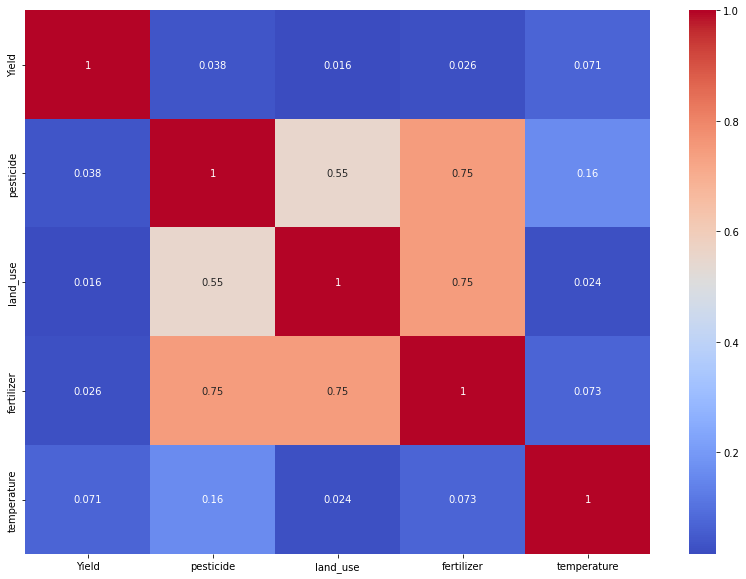

In [ ]:
import seaborn as sns 
plt.figure(figsize=(14,10))
corr = final_df.corr()
map = sns.heatmap(corr, cmap='coolwarm', annot=True)

KeyboardInterrupt: ignored

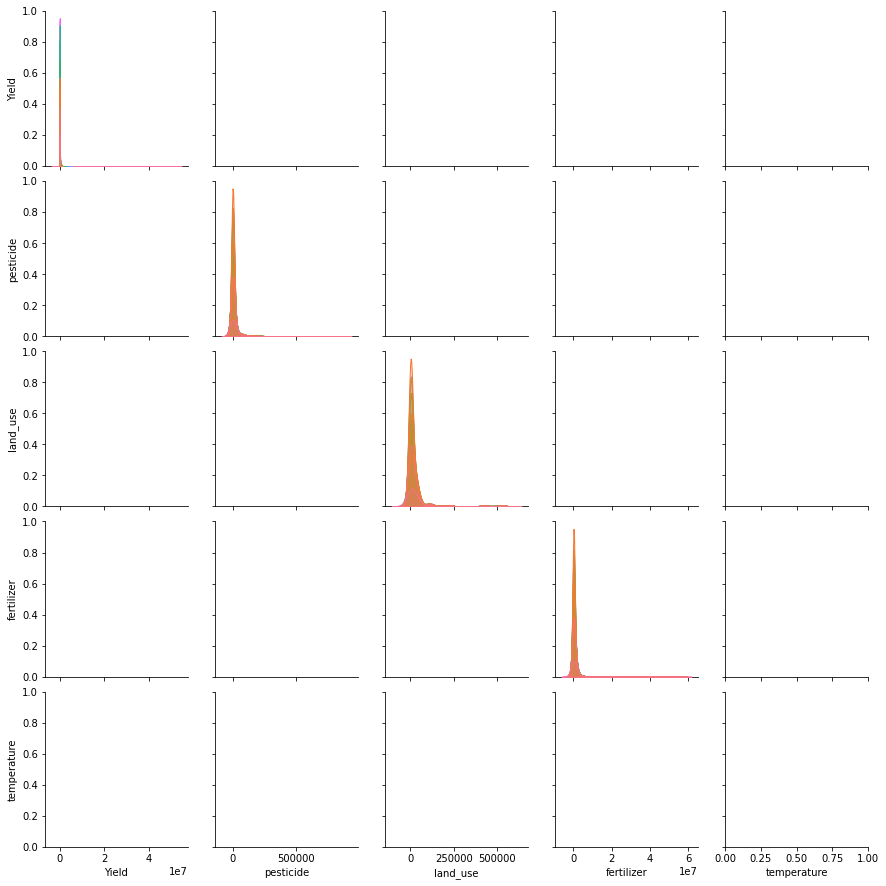

In [ ]:
sns.pairplot(final_df,hue = 'Item')

In [ ]:
final = final_df.groupby("Item").mean().reset_index()
sns.pairplot(final,hue = 'Item')

In [ ]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(20,20))

g= sns.FacetGrid(final_df, col='Item')
g = g.map(sns.distplot, "Date")
plt.show()

Yield             AxesSubplot(0.125,0.749828;0.133621x0.130172)
pesticide      AxesSubplot(0.285345,0.749828;0.133621x0.130172)
land_use        AxesSubplot(0.44569,0.749828;0.133621x0.130172)
fertilizer     AxesSubplot(0.606034,0.749828;0.133621x0.130172)
temperature    AxesSubplot(0.766379,0.749828;0.133621x0.130172)
dtype: object

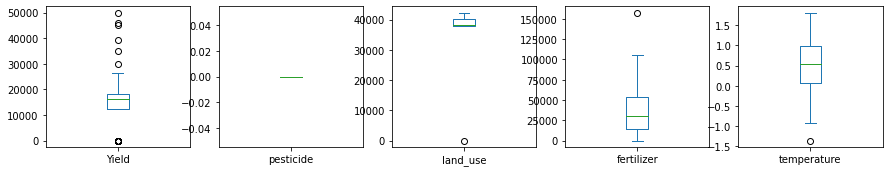

In [ ]:
df = final_df[(final_df['Area'] == 'Afghanistan')]
df = df[(df['Item'] == 'Almonds')]
df.plot(kind="box",subplots=True,layout=(5,5),figsize=(15,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03cd07fa30>,
      dtype=object)

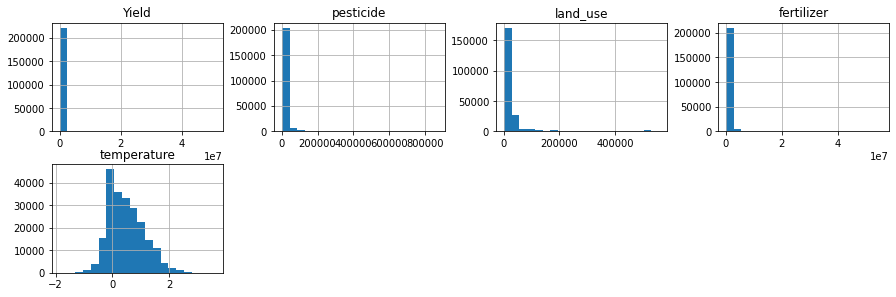

In [ ]:
final_df.hist(figsize=(15,15), layout=(6,4), bins=20 )

NameError: ignored

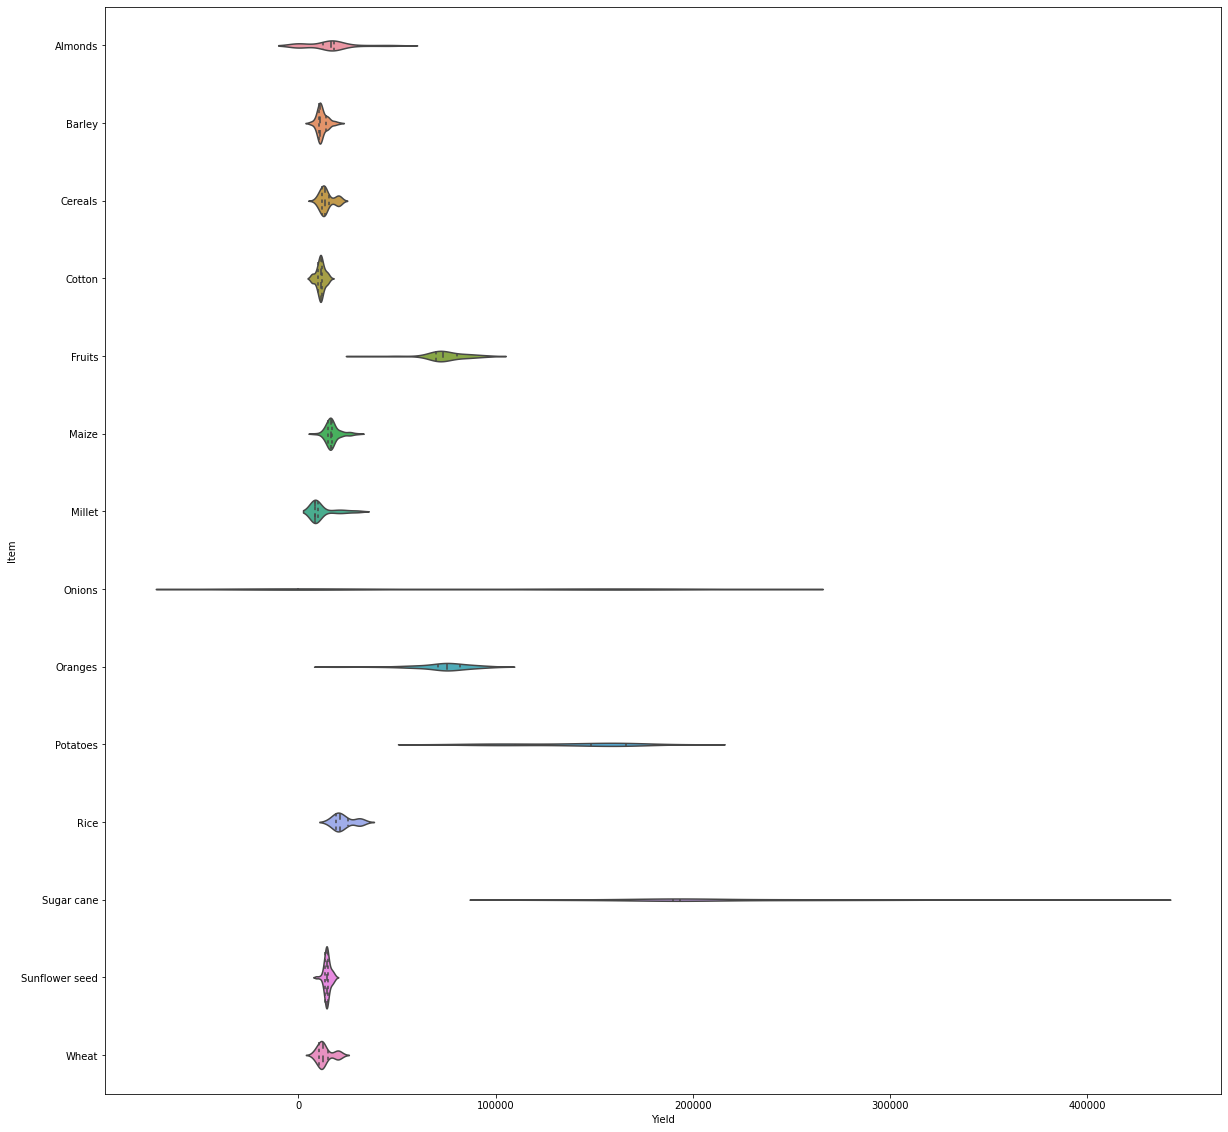

In [ ]:
df = final_df[(final_df['Area'] == 'Afghanistan')]
fig, axes = plt.subplots(1, 1, figsize = (20, 20))
sns.violinplot( x=df["Yield"],y=df["Item"],inner="quartile",axes=axes)
ax.set(xlabel=None)
plt.show()

In [16]:
cols = ['Yield', 'pesticide', 'land_use', 'fertilizer', 'temperature']
ss = MinMaxScaler()
df = final_df[(final_df['Area'] != 'Netherlands')]
df_scaled = pd.DataFrame(ss.fit_transform(df[cols]),columns = cols)

In [17]:
df_scaled['Area'] = df['Area']
df_scaled['CID'] = df['CID']
df_scaled['Item'] = df['Item']
df_scaled['Date'] = df['Date']

In [18]:
df_scaled.head()

,Yield,pesticide,land_use,fertilizer,temperature,Area,CID,Item,Date
0,0.0,0.0,0.067511,0.00002,0.339904,Afghanistan,AFG,Almonds,1961
1,0.0,0.0,0.067619,0.00002,0.296628,Afghanistan,AFG,Almonds,1962
2,0.0,0.0,0.067708,0.00002,0.497632,Afghanistan,AFG,Almonds,1963
3,0.0,0.0,0.067821,0.00002,0.170707,Afghanistan,AFG,Almonds,1964
4,0.0,0.0,0.067825,0.00002,0.328230,Afghanistan,AFG,Almonds,1965


In [ ]:
# d = final_df[(final_df['Area']=='India') & (final_df['Item'] == 'Rice')]
# plt.plot(kind = 'bar',x = d['Yield'] , y = d['Date'])

# Machine Learning Models

In [19]:
final_df.head()

,Area,CID,Item,Date,Yield,pesticide,land_use,fertilizer,temperature
0,Afghanistan,AFG,Almonds,1961,0.0,0.0,37700.0,1100.0,0.000706
1,Afghanistan,AFG,Almonds,1962,0.0,0.0,37760.0,1100.0,-0.235235
2,Afghanistan,AFG,Almonds,1963,0.0,0.0,37810.0,1100.0,0.860647
3,Afghanistan,AFG,Almonds,1964,0.0,0.0,37873.0,1100.0,-0.921765
4,Afghanistan,AFG,Almonds,1965,0.0,0.0,37875.0,1100.0,-0.062941


In [21]:
df_scaled.head()

,Yield,pesticide,land_use,fertilizer,temperature,Area,CID,Item,Date
0,0.0,0.0,0.067511,0.00002,0.339904,Afghanistan,AFG,Almonds,1961
1,0.0,0.0,0.067619,0.00002,0.296628,Afghanistan,AFG,Almonds,1962
2,0.0,0.0,0.067708,0.00002,0.497632,Afghanistan,AFG,Almonds,1963
3,0.0,0.0,0.067821,0.00002,0.170707,Afghanistan,AFG,Almonds,1964
4,0.0,0.0,0.067825,0.00002,0.328230,Afghanistan,AFG,Almonds,1965


In [22]:
df_scaled_grp = df_scaled.groupby(by = ['Date', 'Item'], axis = 0).agg({'Yield' : 'sum', 'pesticide' : 'sum', 'land_use': 'sum', 'fertilizer': 'sum', 
                                                                        'temperature': 'mean'})
df_scaled_grp = df_scaled_grp.reset_index()

df_scaled_grp



,Date,Item,Yield,pesticide,land_use,fertilizer,temperature
0,1961,Almonds,0.036508,0.0,5.230818,0.347006,0.364666
1,1961,Bananas,0.357571,0.0,6.682884,0.365904,0.348380
2,1961,Barley,0.087678,0.0,7.625225,0.549722,0.374977
3,1961,Beans,0.115841,0.0,7.908330,0.530407,0.364213
4,1961,Cabbages,0.504602,0.0,7.699254,0.561840,0.364758
...,...,...,...,...,...,...,...
1947,2021,Sugar cane,1.509458,0.0,0.000000,0.000000,0.567847
1948,2021,Sunflower seed,0.205848,0.0,0.000000,0.000000,0.592202
1949,2021,Tea,0.060803,0.0,0.000000,0.000000,0.557300
1950,2021,Tomatoes,1.354134,0.0,0.000000,0.000000,0.582437


In [23]:
import plotly.express as px
fig = px.box(df_scaled_grp, y=["Yield",'pesticide','land_use', 'fertilizer', 'temperature'] )
fig.show()


In [24]:
df_one_hot = df_scaled_grp.copy(deep =True)
df_one_hot

,Date,Item,Yield,pesticide,land_use,fertilizer,temperature
0,1961,Almonds,0.036508,0.0,5.230818,0.347006,0.364666
1,1961,Bananas,0.357571,0.0,6.682884,0.365904,0.348380
2,1961,Barley,0.087678,0.0,7.625225,0.549722,0.374977
3,1961,Beans,0.115841,0.0,7.908330,0.530407,0.364213
4,1961,Cabbages,0.504602,0.0,7.699254,0.561840,0.364758
...,...,...,...,...,...,...,...
1947,2021,Sugar cane,1.509458,0.0,0.000000,0.000000,0.567847
1948,2021,Sunflower seed,0.205848,0.0,0.000000,0.000000,0.592202
1949,2021,Tea,0.060803,0.0,0.000000,0.000000,0.557300
1950,2021,Tomatoes,1.354134,0.0,0.000000,0.000000,0.582437


In [25]:
df_one_hot.dtypes
df_one_hot['Date'] = pd.to_numeric(df_one_hot['Date'])

In [26]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_one_hot['Item'])
# Drop column B as it is now encoded
df_one_hot = df_one_hot.drop('Item',axis = 1)
# Join the encoded df
df_one_hot = df_one_hot.join(one_hot)
df_one_hot.columns


Index(['Date', 'Yield', 'pesticide', 'land_use', 'fertilizer', 'temperature',
       'Almonds', 'Bananas', 'Barley', 'Beans', 'Cabbages', 'Carrots',
       'Cassava, fresh', 'Cereals', 'Cocoa beans', 'Coffee, green', 'Cotton',
       'Fruits', 'Groundnuts', 'Lemons', 'Lettuce', 'Maize', 'Millet',
       'Mushrooms', 'Oil palm', 'Onions', 'Oranges', 'Peas, green', 'Potatoes',
       'Pumpkins', 'Rice', 'Rye', 'Soya beans', 'Sugar cane', 'Sunflower seed',
       'Tea', 'Tomatoes', 'Wheat'],
      dtype='object')

In [27]:
columns = ['Date', 'pesticide', 'land_use', 'fertilizer', 'temperature',
       'Almonds', 'Bananas', 'Barley', 'Beans', 'Cabbages', 'Carrots',
       'Cassava, fresh', 'Cereals', 'Cocoa beans', 'Coffee, green', 'Cotton',
       'Fruits', 'Groundnuts', 'Lemons', 'Lettuce', 'Maize', 'Millet',
       'Mushrooms', 'Oil palm', 'Onions', 'Oranges', 'Peas, green', 'Potatoes',
       'Pumpkins', 'Rice', 'Rye', 'Soya beans', 'Sugar cane', 'Sunflower seed',
       'Tea', 'Tomatoes', 'Wheat']

In [28]:
from sklearn.model_selection import train_test_split

X= df_one_hot[columns]
y=df_one_hot['Yield']

# using the train test split function
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=99, 
                                   test_size=0.25, 
                                   shuffle=True)
  
# # printing out train and test sets
  
# print('X_train : ')
# print(X_train.head())
# print('')
# print('X_test : ')
# print(X_test.head())
# print('')
# print('y_train : ')
# print(y_train.head())
# print('')
# print('y_test : ')
# print(y_test.head())

### Random Forest

In [34]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor

# create regressor object
regressor = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18).fit(X_train, y_train)


In [31]:
import pprint

print(regressor.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 18, 'verbose': 0, 'warm_start': False}


In [35]:
from sklearn.metrics import mean_squared_error

prediction = regressor.predict(X_train)
mse = mean_squared_error(y_train, prediction)
rmse = mse**.5

print("Train Root Mean Squared Error of Random Forest is: ", round(rmse, 5))

Train Root Mean Squared Error of Random Forest is:  0.21067


In [36]:
from sklearn.metrics import mean_squared_error
y_test_pred_rf = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred_rf)
rmse = mse**.5

print("Test Root Mean Squared Error of Random Forest is: ", round(rmse, 5))

Test Root Mean Squared Error of Random Forest is:  0.20233


### LightGBM

In [ ]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.01,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 4,
    'verbose': 0,
    "max_depth": 4,
    "num_leaves": 4,  
    "max_bin": 8,
    "num_iterations": 200
}

In [ ]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X_train, y_train,eval_set=[(X_test, y_test)],eval_metric='l1',early_stopping_rounds=10)

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[1]	valid_0's l1: 0.261332	valid_0's l2: 0.123635
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 0.26071	valid_0's l2: 0.123143
[3]	valid_0's l1: 0.259776	valid_0's l2: 0.122354
[4]	valid_0's l1: 0.259003	valid_0's l2: 0.121614
[5]	valid_0's l1: 0.25792	valid_0's l2: 0.120464
[6]	valid_0's l1: 0.257037	valid_0's l2: 0.119674
[7]	valid_0's l1: 0.256218	valid_0's l2: 0.118878
[8]	valid_0's l1: 0.255438	valid_0's l2: 0.118087
[9]	valid_0's l1: 0.254677	valid_0's l2: 0.117356
[10]	valid_0's l1: 0.253885	valid_0's l2: 0.116652
[11]	valid_0's l1: 0.253071	valid_0's l2: 0.115921
[12]	valid_0's l1: 0.252307	valid_0's l2: 0.115241
[13]	valid_0's l1: 0.251344	valid_0's l2: 0.114264
[14]	valid_0's l1: 0.250559	valid_0's l2: 0.113517
[15]	valid_0's l1: 0.249694	valid_0's l2: 0.112602
[16]	valid_0's l1: 0.248751	valid_0's l2: 0.11167
[17]	valid_0's l1: 0.248072	valid_0's l2: 0.110954
[18]	valid_0's l1: 0.247202	valid_0's l2: 0.110057
[19]	valid_0's l1: 0.246467	vali

LGBMRegressor(bagging_fraction=0.7, bagging_freq=4, feature_fraction=0.7,
              learning_rate=0.01, max_bin=8, max_depth=4, metric=['l1', 'l2'],
              num_iterations=200, num_leaves=4, objective='regression',
              task='train', verbose=0)

In [ ]:
y_train_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)

In [ ]:
print('The rmse of prediction is:', round(mean_squared_error(y_train_pred, y_train) ** 0.5, 5))

The rmse of prediction is: 0.22606


In [ ]:
y_test_pred = np.expm1(gbm.predict(X_test, num_iteration=gbm.best_iteration_))

In [ ]:
print('The rmse of prediction is:', round(mean_squared_error(y_test_pred, y_test) ** 0.5, 5))

The rmse of prediction is: 0.2495


### XGBoost Model

In [56]:
pip install xgboost==1.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.7 MB 112.1 MB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [58]:
# check xgboost version
import xgboost as xg
print(xgboost.__version__)

NameError: ignored

In [ ]:
# create an xgboost regression model
xgb_r = xg.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [54]:
print(xgb_r.get_params())

NameError: ignored

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xgb_r, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

In [ ]:
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: -0.040 (0.013)


In [ ]:
from sklearn.metrics import mean_squared_error as mean_squared_error

# Fitting the model
xgb_r.fit(X_train, y_train)

# Predict the model
pred = xgb_r.predict(X_train)

# RMSE Computation
rmse = np.sqrt(mean_squared_error(y_train, pred))
print("RMSE : % f" %(rmse))

RMSE :  0.000635


In [ ]:
# Predict the model
pred = xgb_r.predict(X_test)

# RMSE Computation
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE : % f" %(rmse))

RMSE :  0.051147


##Train Test Split - LSTM

In [42]:
# Importing Training Set
dataset_train = df_scaled[(df_scaled['Area']=='India') & (df_scaled['Item'] == 'Rice')]
cols = ['Date', 'pesticide', 'land_use', 'fertilizer', 'temperature', 'Yield']

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))



Training set shape == (61, 9)
All timestamps == 61
Featured selected: ['Date', 'pesticide', 'land_use', 'fertilizer', 'temperature', 'Yield']


In [43]:
df_1 = df_scaled[(df_scaled['Area']=='India') & (df_scaled['Item'] == 'Maize')]
# df_1 = df_scaled.groupby(['Item', 'Date']).mean().reset_index()
# df_1 = df_1[df_1['Item'] == 'Rice']
# df_2_Date = df_1[['Date']]
df_2_train = df_1.iloc[:54,:5]
df_2_test = df_1.iloc[54:,:5]

In [44]:
df_2_scaled = df_2_train
df_2_scaled_y = list(df_2_scaled['Yield'])

In [45]:
len(df_2_scaled_y)


54

In [46]:
len(df_1)

61

In [47]:
hops = 4
records = 54
no_cols = 5
X_train = []
y_train = []
for i in range(4,54):
  X_train.append(df_2_scaled[i-4:i])
  y_train.append(df_2_scaled_y[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [48]:
X_train.shape, y_train.shape

((50, 4, 5), (50,))

In [49]:
model=Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(4,5)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [50]:
model.fit(X_train, y_train, epochs =20, batch_size=2, verbose=0)

In [51]:
model.summary()

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_158 (LSTM)             (None, 4, 20)             2080      
                                                                 
 dropout_158 (Dropout)       (None, 4, 20)             0         
                                                                 
 lstm_159 (LSTM)             (None, 50)                14200     
                                                                 
 dropout_159 (Dropout)       (None, 50)                0         
                                                                 
 dense_79 (Dense)            (None, 1)                 51        
                                                                 
Total params: 16,331
Trainable params: 16,331
Non-trainable params: 0
_________________________________________________________________


In [52]:
full_df = pd.concat((df_2_test, df_2_train[-4:]), axis=0)
full_df.shape

(11, 5)

In [ ]:
hops = 4
records = 11
no_cols = 5
X_train_pred = []
for i in range(4,11):
  X_train_pred.append(full_df[i-4:i])
X_train_pred = np.array(X_train_pred)
X_train_pred.shape

(7, 4, 5)

In [ ]:
preds = model(X_train_pred, training=False)
preds.numpy().reshape((len(preds)))

array([0.00049825, 0.00054694, 0.00047139, 0.00020543, 0.00027534,
       0.00040653, 0.00066871], dtype=float32)

In [ ]:
true = list(df_1['Yield'][-7:])

In [ ]:
from sklearn.metrics import mean_squared_error
import math

math.sqrt(mean_squared_error(preds, true))

0.0005994152374174648

In [ ]:
len(list(df_1['Yield']))

61

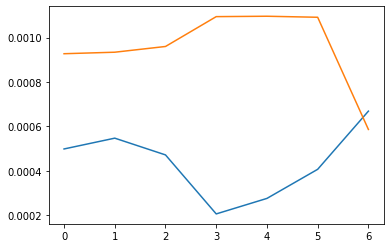

In [ ]:
plt.plot(preds)
plt.plot(true)

### LSTM FINAL

In [ ]:
data_scaled_trim = data_scaled['Yield']

In [37]:
from sklearn.metrics import mean_squared_error
import math

In [38]:
def lstm(area, item, data):    
    # Importing Training Set
    # dataset_train = df_scaled[(df_scaled['Area']=='area') & (df_scaled['Item'] == 'item')]
    # cols = ['Date', 'pesticide', 'land_use', 'fertilizer', 'temperature', 'Yield']

    # # Extract dates (will be used in visualization)
    # datelist_train = list(dataset_train['Date'])

    # print('Training set shape == {}'.format(dataset_train.shape))
    # print('All timestamps == {}'.format(len(datelist_train)))
    # print('Featured selected: {}'.format(cols))
    
    df_1 = data[(data['Area']==area) & (data['Item'] == item)]
    #print('df_1: ', df_1)
    df_2_train = df_1.iloc[:54,:5]
    #print('train',df_2_train)
    df_2_test = df_1.iloc[54:,:5]
    #print('test', df_2_test)

    df_2_scaled = df_2_train
    #print(df_2_train)
    df_2_scaled_y = list(df_2_scaled['Yield'])



    X_train = []
    y_train = []
    #print(len(df_2_scaled_y))
    for i in range(4,54):
        X_train.append(df_2_scaled[i-4:i])
        y_train.append(df_2_scaled_y[i])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # X_train.shape, y_train.shape

    model=Sequential()
    model.add(LSTM(units=20, return_sequences=True, input_shape=(4,5)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, epochs =20, batch_size=2, verbose=0)

    full_df = pd.concat((df_2_test, df_2_train[-4:]), axis=0)
    full_df.shape

    X_train_pred = []

    for i in range(4,11):
        X_train_pred.append(full_df[i-4:i])
    X_train_pred = np.array(X_train_pred)
    X_train_pred.shape

    preds = model(X_train_pred, training=False)
    preds.numpy().reshape((len(preds)))

    true = list(df_1['Yield'][-7:])

    rmse_model = math.sqrt(mean_squared_error(preds, true))

    return rmse_model


In [39]:
def lstm_final(data):
   
    item_list = []
    area_list = []
    rmse_list = []


    area_list = data['Area'].unique()
    item_list = data['Item'].unique()
    

    for area in area_list[:10]:
      # print(area)
      for item in item_list[:10]:
        # print(item)
        try:
        #print(data.head())
            rmse_final = lstm(area, item, data)
            rmse_list.append(rmse_final)
        except:
           continue
      

    return np.mean(rmse_list)




In [40]:
rmse_mean = lstm_final(df_scaled)

In [41]:
print("The Avg RMSE for the LSTM model is: ", rmse_mean)

The Avg RMSE for the LSTM model is:  0.0015657703476377233
